In [494]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer

In [495]:
# First load and check the data
# Load the dataset as 'Pandas Dataframe' object.
df = pd.read_csv('datasets_houses.csv')

In [496]:
# Check if any of the values in
# the 'GarageArea' or 'SalePrice' columns are empty.
print("Any empty values in 'GarageArea' column?",
       df['GarageArea'].isnull().values.any())
print("Any empty values in 'SalePrice' column?",
       df['SalePrice'].isnull().values.any())

Any empty values in 'GarageArea' column? False
Any empty values in 'SalePrice' column? False


In [497]:
# Extract the two columns from the dataframe.
# We are predicting 'SalePrice'.
X = df[['GarageArea']].values
y = df['SalePrice'].values

# First check the ranges of the variables.
print("Min-Max GarageArea: %d-%d" %(X.min(),X.max()))
print("Min-Max SalePrice: %d-%d" %(y.min(),y.max()))

Min-Max GarageArea: 0-1418
Min-Max SalePrice: 34900-755000


There is quite a difference in the range of the two variables so some sort of scaling may be required.

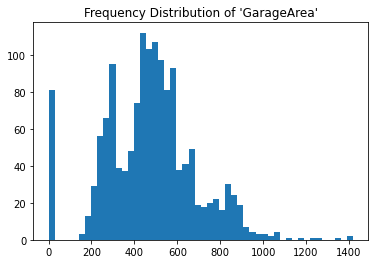

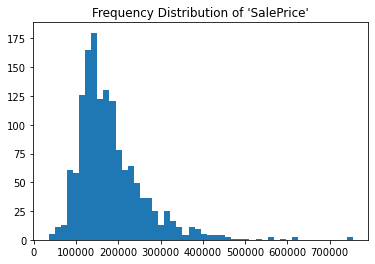

In [498]:
# Now check the distribution of the 
# 'GarageArea' and 'SalePrice' datasets.
plt.hist(X, bins=50)
plt.title("Frequency Distribution of 'GarageArea'")
plt.show()
plt.hist(y, bins=50)
plt.title("Frequency Distribution of 'SalePrice'")
plt.show()

It can be seen that both 'GarageArea' and 'SalePrice' do not exactly have a Normal/Gaussian distribution and 'SalePrice' is skewed towards the left.
They also appear to have outliers on the far left and right.

In [499]:
# Begin preparation of the data.
# First split the dataset into train/test subsets.
# The ratio picked will be 0.6:0.4 because there are 1460 houses
# so 60% of that should be enough to train the model.
# Fix the random state to get the same split everytime.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.6, random_state = 1)

In [500]:
# We know from before that the dataset is skewed and also has outliers.
# Outliers are known to affect MinMaxScaler and StandardScaler,
# since they use the mean and standard deviation to scale the data.
# We will instead use RobustScaler which scales according to the IQR (Interquartile Range).
# Scale both 'X' and 'y'.
scaler_X = RobustScaler()
scaler_X.fit(X_train)
X_train = scaler_X.transform(X_train)
X_test = scaler_X.transform(X_test)

In [501]:
# Scaler requires a dataframe object, so convert y_train and y_test
# to dataframes when transforming.
# Later when the data is fitted, 'y' will need to be 1D array,
# so use flatten().
scaler_y = RobustScaler()
scaler_y.fit(pd.DataFrame(y_train))
y_train = scaler_y.transform(pd.DataFrame(y_train)).flatten()
y_test = scaler_y.transform(pd.DataFrame(y_test)).flatten()

Random Forest Regression
with RobustScaler:
MSE train: 0.23582, test: 0.60911
R^2 train: 0.74520, test: 0.35628


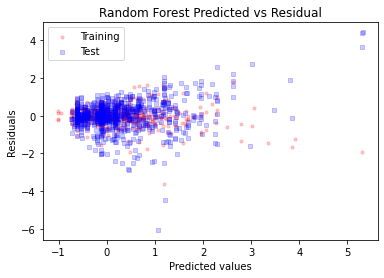

In [502]:
# Now perform Random Forest on the training data.
# We are only using one variable 'GarageArea' to predict 'SalePrice'
# thus the number of trees needed does not need to be too large,
# but maximising 'n_estimators' can help remove prediction variance.
# Use mean squared error to determine the best tree splits.
forest = RandomForestRegressor(n_estimators = 500,
                               criterion = 'mse',
                               random_state = 40)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
print("Random Forest Regression\nwith RobustScaler:")
print('MSE train: %.5f, test: %.5f' %(
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.5f, test: %.5f' %(
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

# Plot a scatter graph of the predicted 'SalesPrice'
# against the residual (minus actual value)
plt.scatter(y_train_pred,
            y_train_pred - y_train,
            c='red',
            marker='o',
            s=10,
            alpha=0.2,
            label='Training')
plt.scatter(y_test_pred,
            y_test_pred - y_test,
            c='blue',
            marker='s',
            s=10,
            alpha=0.2,
            label='Test')
plt.title('Random Forest Predicted vs Residual')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend()
plt.show()

Linear Regression		
with RobustScaler:
MSE train: 0.59576, test: 0.55900
R^2 train: 0.35630, test: 0.40924
RL Slope: 0.66614
RL Intercept: 0.24172


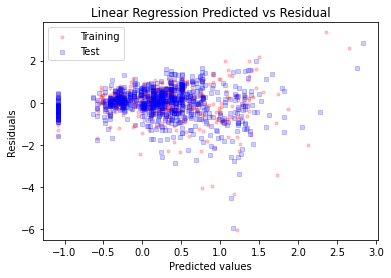

In [503]:
# Now perform Linear Regression on the training data.
lin = LinearRegression()
lin.fit(X_train, y_train)
y_train_pred = lin.predict(X_train)
y_test_pred = lin.predict(X_test)
print("Linear Regression\
		\nwith RobustScaler:")
print('MSE train: %.5f, test: %.5f' %(
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.5f, test: %.5f' %(
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))
print('RL Slope: %.5f' %(lin.coef_[0]))
print('RL Intercept: %.5f' %(lin.intercept_))

# Plot a scatter graph of the predicted 'SalesPrice'
# against the residual (minus actual value).
plt.scatter(y_train_pred,
            y_train_pred - y_train,
            c='red',
            marker='o',
            s=10,
            alpha=0.2,
            label='Training')
plt.scatter(y_test_pred,
            y_test_pred - y_test,
            c='blue',
            marker='s',
            s=10,
            alpha=0.2,
            label='Test')
plt.title('Linear Regression Predicted vs Residual')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend()
plt.show()

We can see that heteroscedasticity is present in the residuals, which can impact MSE used for the random forest splits and OLS used for linear regression.

In [504]:
# To combat this heteroscedasticity, we can perform a yeo-johnson transformation
# on the target feature in an attempt to make the residuals homoscedastic.
scaler_p = PowerTransformer(method='yeo-johnson')
scaler_p.fit(pd.DataFrame(y_train))
y_train = scaler_p.transform(pd.DataFrame(y_train)).flatten()
y_test = scaler_p.transform(pd.DataFrame(y_test)).flatten()

Random Forest Regression with Max Depth = 5		
with RobustScaler and Yeo-Johnson:
MSE train: 0.45127, test: 0.61055
R^2 train: 0.54873, test: 0.45672


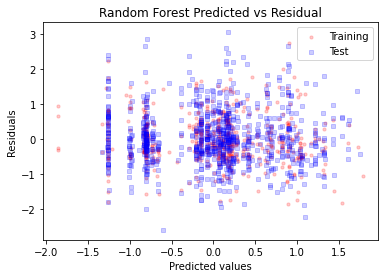

In [505]:
# Now set a 'max_depth' for the decision trees
# in the random forest, as a hyperparameter.
# The default setting allows the decision tree
# to keep expanding until it is 'pure'.
# Setting 'max_depth' can help prevent overfitting.
# 'n_estimators' is already at quite a high value of 500,
# so it does not need to be changed even if we are
# setting a value for 'max_depth'.
forest = RandomForestRegressor(n_estimators = 500,
                               criterion = 'mse',
                               random_state = 40,
			       max_depth = 5) # New hyperparameter
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
print("Random Forest Regression with Max Depth = 5\
		\nwith RobustScaler and Yeo-Johnson:")
print('MSE train: %.5f, test: %.5f' %(
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.5f, test: %.5f' %(
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

# Plot a scatter graph of the predicted 'SalesPrice'
# against the residual (minus actual value).
plt.scatter(y_train_pred,
            y_train_pred - y_train,
            c='red',
            marker='o',
            s=10,
            alpha=0.2,
            label='Training')
plt.scatter(y_test_pred,
            y_test_pred - y_test,
            c='blue',
            marker='s',
            s=10,
            alpha=0.2,
            label='Test')
plt.title('Random Forest Predicted vs Residual')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend()
plt.show()

We can see that the residuals are no longer heteroscedastic.

Linear Regression		
with RobustScaler and Yeo-Johnson:
MSE train: 0.61036, test: 0.63127
R^2 train: 0.38964, test: 0.43828
RL Slope: 0.72409
RL Intercept: 0.00759


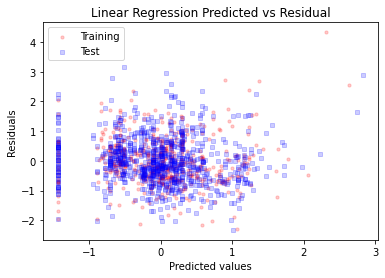

In [506]:
# Now perform Linear Regression on the training data.
lin = LinearRegression()
lin.fit(X_train, y_train)
y_train_pred = lin.predict(X_train)
y_test_pred = lin.predict(X_test)
print("Linear Regression\
		\nwith RobustScaler and Yeo-Johnson:")
print('MSE train: %.5f, test: %.5f' %(
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.5f, test: %.5f' %(
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))
print('RL Slope: %.5f' %(lin.coef_[0]))
print('RL Intercept: %.5f' %(lin.intercept_))

# Plot a scatter graph of the predicted 'SalesPrice'
# against the residual (minus actual value).
plt.scatter(y_train_pred,
            y_train_pred - y_train,
            c='red',
            marker='o',
            s=10,
            alpha=0.2,
            label='Training')
plt.scatter(y_test_pred,
            y_test_pred - y_test,
            c='blue',
            marker='s',
            s=10,
            alpha=0.2,
            label='Test')
plt.title('Linear Regression Predicted vs Residual')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend()
plt.show()

Once again, the residuals are not heteroscedastic.

Decision Tree		
with RobustScaler and Yeo-Johnson:
MSE train: 0.54658, test: 0.66751
R^2 train: 0.45342, test: 0.40603


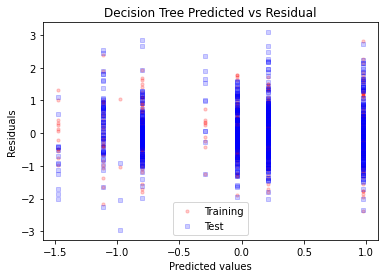

In [507]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X_train, y_train)

y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
print("Decision Tree\
		\nwith RobustScaler and Yeo-Johnson:")
print('MSE train: %.5f, test: %.5f' %(
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.5f, test: %.5f' %(
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

plt.scatter(y_train_pred,
            y_train_pred - y_train,
            c='red',
            marker='o',
            s=10,
            alpha=0.2,
            label='Training')
plt.scatter(y_test_pred,
            y_test_pred - y_test,
            c='blue',
            marker='s',
            s=10,
            alpha=0.2,
            label='Test')
plt.title('Decision Tree Predicted vs Residual')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend()
plt.show()

LASSO		
with RobustScaler and Yeo-Johnson:
LASSSO MSE train: 0.624, test: 0.659
LASSO R^2 train: 0.376, test: 0.414


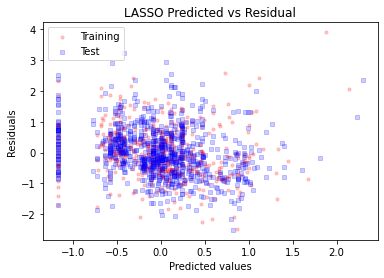

In [508]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)

print("LASSO\
		\nwith RobustScaler and Yeo-Johnson:")
print('LASSSO MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('LASSO R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

plt.scatter(y_train_pred,
            y_train_pred - y_train,
            c='red',
            marker='o',
            s=10,
            alpha=0.2,
            label='Training')
plt.scatter(y_test_pred,
            y_test_pred - y_test,
            c='blue',
            marker='s',
            s=10,
            alpha=0.2,
            label='Test')
plt.title('LASSO Predicted vs Residual')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend()
plt.show()